In [2]:
pip install python-docx

     |████████████████████████████████| 5.6 MB 5.2 MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184508 sha256=0d50dc5991796fc868990b4485b23e5ba7bad2bb79fb1344477e6759db1adab6
  Stored in directory: /root/.cache/pip/wheels/f6/6f/b9/d798122a8b55b74ad30b5f52b01482169b445fbb84a11797a6
Successfully built python-docx


In [8]:
import docx

import glob
import re
import pandas as pd
#from yattag import Doc
import unicodedata
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

In [9]:
def getText(filename):
    doc = docx.Document(filename)
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    return fullText


In [10]:
texto = getText('dodf43-62.docx')
for txt in texto:
  print(txt)

EXTRATO DO CONTRATO Nº 10/2013. Processo 040.004.068/2012 - Partes: DF/SEF X ORACLE DO BRASIL SISTEMAS LTDA. Objeto: O Contrato tem por objeto a prestação de serviços a serem executados de forma contínua, correspondentes a suporte técnico remoto 24x7 (24 horas por dia, sete dias por semana) para os softwares da ORACLE, com atualização dos softwares, de acordo com o Projeto Básico, fls. (290 a 300), o Parecer nº 1.323/2012 - PROCAD/PGDF, fls.(333 a 357), os despachos de reconhecimento fls. (423) e de ratificação da inexigibilidade de licitação fl. (413) e a Proposta da ORACLE fls. (454 a 492). Valor: O valor total do Contrato é de R$ 2.703.443,58 (dois milhões, setecentos e três mil, quatrocentos e quarenta e três reais e cinquenta e oito centavos), devendo a importância de R$ 2.252.869,65 (dois milhões, duzentos e cinquenta e dois mil, oitocentos e sessenta e nove reais e sessenta e cinco centavos) ser atendida à conta de dotações orçamentárias consignadas no orçamento corrente – Lei O

In [11]:
# primeiro teste de extração do contrato
regex_contrato = 'EXTRATO DO CONTRATO ([^.]*)'
df_dict=[]

# txt=str(txt).strip('[]')

for txt in texto:
  #print(txt)
  match = re.search(regex_contrato, txt, re.IGNORECASE)
  if match:
      df_dict.append(match.group(0))
  else:
      df_dict.append(np.nan)
    
print(df_dict)    

['EXTRATO DO CONTRATO Nº 10/2013', 'EXTRATO DO CONTRATO Nº 11/2013', 'EXTRATO DO CONTRATO Nº 38/2013', 'EXTRATO DO CONTRATO Nº 39/2013', 'EXTRATO DO CONTRATO Nº 13/2014-SEF PROCESSO N', nan, 'EXTRATO DO CONTRATO Nº 04/2014', 'EXTRATO DO CONTRATO Nº 05/2014', 'EXTRATO DO CONTRATO Nº 60/2017 PROCESSO SEI nº 040', 'EXTRATO DO CONTRATO Nº 48/2017 PROCESSO SEI nº 040', 'EXTRATO DO CONTRATO Nº 51/2015', 'EXTRATO DO CONTRATO Nº 52/2016', 'EXTRATO DO CONTRATO Nº 044/2015', 'EXTRATO DO CONTRATO Nº 016/2016', 'EXTRATO DO CONTRATO Nº 79/2017 PROCESSO: 00040-00054001/2017-81 - DAS PARTES: SEF/DF X BSB TIC SOLUÇÕES LTDA - EPP', 'EXTRATO DO CONTRATO Nº 61/2017 PROCESSO: 040', nan, 'EXTRATO DO CONTRATO Nº 40/2017 PROCESSO SEI Nº 040']


In [15]:
# regex dos varios atributos
regex_dict={
    'contrato': '(EXTRATO DO[\s\S]*CONTRATO Nº[\s\S](\d{2}/\d{4}?)|EXTRATO DO[\s\S]*CONTRATO Nº[\s\S](\d{3}/\d{4}?)|EXTRATO DO[\s\S]*CONTRATO Nº[\s\S](\d{4}/\d{4}?))', # Numero do ajuste
    # 'contrato': 'EXTRATO DO[\s\S]*CONTRATO Nº (\d{2}/\d{4}?)|(\d{3}/\d{4}?)|(\d{4}/\d{4}?)', 
    'partes':'(Partes:[\s\S]([^.]*))', # Orgao contratante X entidade contratada
    # Entidade convenentes???
    'processo': '(Processo[\s\S]*(\d{3}.\d{3}/\d{4}?)|Processo[\s\S]*(\d{3}.\d{3}/.\d{5}/\d{4}-\d{2})|Processo[\s\S]*(\d{3}.\d{6}/\d{4}?))' , # Processo no GDF
    # 'processo': 'Processo[\s\S]*(\d{3}.\d{6}/\d{4}?)|(\d{5}[\.|\-]\d{8}\/\d{4}-\d{2})|(\d{5}[\.|\-]\d{8}\/\d{4}-\d{2})', # outros formatos de processos
    'objeto':'([DO]?Objeto[\s\S]([^.]*)|Contrato tem por objeto ([^.]*))', # Objeto do ajuste
    'data_ass': 'Data da Assinatura:[\s\S](\d{2}/\d{2}/\d{2}?)', # Data
    'vigencia':'(Vigência[\s\S]([^.]*))', # Vigencia do ajuste
    'valor': '(Valor:[\s\S]([^(]*))', # Valor do ajuste
    'uni_orc':'(Unidade Orçamentária[\s\S]([^;|.|,]*))', # Dotacao orcamenteria com: Unidade Orçamentária
    'prog_trab':'(Programa de Trabalho[\s\S]([^,|;]*)|PT:[\s\S]([^,|;]*))',# Programa de Trabalho
    'nat_desp':'(Natureza da Despesa[\s\S]([^;]*)|NP:[\s\S]([^;]*))', # Natureza da Despesa
    'nota_emp':'(Nota de Empenho[\s\S]([^;]*)|NE:[\s\S]([^;]*))', #Nota de Empenho (nao tem)
    'numero_ajuste': 'Número do ajuste: ([^;]*)',
    'orgao_contratante': 'Órgão contratante: ([^;]*)',
    'entidade_contratada': 'Entidade contratada: ([^;]*)',
    'entidade_convenente': 'Entidades convenentes: ([^;]*)',

    # Quando contrato decorrente de licitação:
    # orgão licitante
    # numero da licitação

    # quando o contrato pe decorrente de adesão Arp:
    # Orgão gerenciador da ata
    # UF do OG
    # numero do edital do OG
    # Ano o edital do OG

    # Quando o contrato decorrente de dispensa o inexigibilidade:
    # Fundamento lega da dispensa ou inexigibilidade
    # Caso o fundamento legal não seja informado, indentificar se foi dispensa de licitação ou inexigibilidade

}

df_dict={
    'contrato':[],
    'partes':[],
    'processo':[],
    'data_ass':[],
    'objeto':[],
    'vigencia':[],
    'valor':[],
    'uni_orc':[],
    'prog_trab':[],
    'nat_desp':[],
    'nota_emp':[],
    'numero_ajuste': [],
    'orgao_contratante': [],
    'entidade_contratada': [],
    'entidade_convenente': [],
    
}


for txt in texto:
  for field in regex_dict:
    match = re.search(regex_dict[field], txt, re.IGNORECASE)
    if match:
        # res = tuple(x for x in match.groups() if x is not None) #pega sem as palavras usadas como parametros de extraçao 
        # df_dict[field].append(res[0])
        df_dict[field].append(match.group(1)) #pega com as palavras usadas como parametros de extraçao junto no 0 ou sem no 1
    else:
        df_dict[field].append(np.nan)    
    
for field in df_dict:
  print(field, "->", df_dict[field])  


df = pd.DataFrame.from_dict(df_dict)
df.to_csv('abertura_regex.csv')
df  

contrato -> ['EXTRATO DO CONTRATO Nº 10/2013', 'EXTRATO DO CONTRATO Nº 11/2013', 'EXTRATO DO CONTRATO Nº 38/2013', 'EXTRATO DO CONTRATO Nº 39/2013', 'EXTRATO DO CONTRATO Nº 13/2014', 'EXTRATO DO SEGUNDO TERMO ADITIVO AO CONTRATO Nº 50/2013', 'EXTRATO DO CONTRATO Nº 04/2014', 'EXTRATO DO CONTRATO Nº 05/2014', 'EXTRATO DO CONTRATO Nº 60/2017', 'EXTRATO DO CONTRATO Nº 48/2017', 'EXTRATO DO CONTRATO Nº 51/2015', 'EXTRATO DO CONTRATO Nº 52/2016', 'EXTRATO DO CONTRATO Nº 044/2015', 'EXTRATO DO CONTRATO Nº 016/2016', 'EXTRATO DO CONTRATO Nº 79/2017', 'EXTRATO DO CONTRATO Nº 61/2017', nan, 'EXTRATO DO CONTRATO Nº 40/2017']
partes -> ['Partes: DF/SEF X ORACLE DO BRASIL SISTEMAS LTDA', 'Partes: DF/SEF X ORACLE DO BRASIL SISTEMAS LTDA', 'Partes: DF/SEF x PAULISTA SERVIÇOS E TRANSPORTES LTDA', 'Partes: DF/SEF x PAULISTA SERVIÇOS E TRANSPORTES LTDA', 'PARTES: DF/SEF X', 'PARTES: DF/SEF X EMIBM ENGENHARIA E COMÉRCIO LTDA', 'Partes: DF/SEF X Serviço Federal de Processamento de Dados – SERPRO', 'Parte

,contrato,partes,processo,data_ass,objeto,vigencia,valor,uni_orc,prog_trab,nat_desp,nota_emp,numero_ajuste,orgao_contratante,entidade_contratada,entidade_convenente
0,EXTRATO DO CONTRATO Nº 10/2013,Partes: DF/SEF X ORACLE DO BRASIL SISTEMAS LTDA,Processo 040.004.068/2012,25/02/20,Objeto: O Contrato tem por objeto a prestação ...,NaN,Valor: O valor total do Contrato é de R$ 2.703...,Unidade Orçamentária: 19101,Programa de Trabalho: 04.126.6203.1471.0012,Natureza da Despesa: 339039,NaN,NaN,NaN,NaN,NaN
1,EXTRATO DO CONTRATO Nº 11/2013,Partes: DF/SEF X ORACLE DO BRASIL SISTEMAS LTDA,Processo 040.003.743/2011,25/02/20,Objeto: O Contrato tem por objeto a prestação ...,NaN,Valor: O valor total do Contrato é de R$ 120.7...,Unidade Orçamentária: 19101,Programa de Trabalho: 04126620325570007,Natureza da Despesa: 339039,NaN,NaN,NaN,NaN,NaN
2,EXTRATO DO CONTRATO Nº 38/2013,Partes: DF/SEF x PAULISTA SERVIÇOS E TRANSPORT...,Processo 040.001.626/2013,09/07/20,Objeto: O Contrato tem por objeto a contrataçã...,Vigência: O contrato terá vigência de 12 (doze...,Valor: O valor total do Contrato é de R$ 920.7...,Unidade Orçamentária: 130103,Programa de Trabalho: 04122.6003.8517.0051,Natureza da Despesa: 33.90.37,NaN,NaN,NaN,NaN,NaN
3,EXTRATO DO CONTRATO Nº 39/2013,Partes: DF/SEF x PAULISTA SERVIÇOS E TRANSPORT...,Processo 040.001.797/2013,09/07/20,Objeto: O Contrato tem por objeto a contrataçã...,Vigência: O contrato terá vigência de 12 (doze...,Valor: O valor total do Contrato é de R$ 635.5...,Unidade Orçamentária: 130103,Programa de Trabalho: 04122.6003.8517.0051,Natureza da Despesa: 33.90.37,NaN,NaN,NaN,NaN,NaN
4,EXTRATO DO CONTRATO Nº 13/2014,PARTES: DF/SEF X,PROCESSO N.º 040.000.392/2014,18/03/20,OBJETO: O Contrato tem por objeto a contrataçã...,VIGÊNCIA: O contrato terá vigência de 30 (trin...,VALOR: O valor total do Contrato é de R$ 2.187...,Unidade Orçamentária: 19101,Programa de Trabalho; 04126620325570007,Natureza da Despesa: 339039,NaN,NaN,NaN,NaN,NaN
5,EXTRATO DO SEGUNDO TERMO ADITIVO AO CONTRATO N...,PARTES: DF/SEF X EMIBM ENGENHARIA E COMÉRCIO LTDA,PROCESSO N.º 040.003.563/2013,18/03/20,OBJETO: O Termo Aditivo objetiva a alteração c...,VIGÊNCIA: O presente Termo Aditivo entra em vi...,VALOR: O valor total desta prorrogação é de R$...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,EXTRATO DO CONTRATO Nº 04/2014,Partes: DF/SEF X Serviço Federal de Processame...,Processo: 040.000.460/2012,31/01/20,Objeto: Prestação de serviços a serem executad...,Vigência: O contrato terá vigência de 12 (doze...,Valor: O valor total do contrato é de R$ 1.041...,Unidade Orçamentária: 130103,Programa de Trabalho; 04126620325570007,Natureza da Despesa: 339039,"Nota de Empenho n º 2014NE00094, emitida em 31...",NaN,NaN,NaN,NaN
7,EXTRATO DO CONTRATO Nº 05/2014,Partes: DF/SEF X empresa HBL – CARIMBOS E PLAC...,Processo: 040.004.270/2013,31/01/20,OBJETO: Contratação de empresa especializada n...,Vigência: O contrato terá vigência de 12 (doze...,Valor: O valor total do Contrato é de R$ 29.38...,Unidade Orçamentária: 19101,Programa de Trabalho; 04122600385170051,Natureza da Despesa: 339030 e 339030,"Nota de Empenho nº 2014NE00023, emitida em 23/...",NaN,NaN,NaN,NaN
8,EXTRATO DO CONTRATO Nº 60/2017,PARTES: SEF X ALSAR TECNOLOGIA EM REDES LTDA,PROCESSO SEI nº 040.00056829/2017,31/08/20,Contrato tem por objeto a contratação de empre...,VIGÊNCIA: O Contrato terá vigência de 60 (sess...,VALOR: O valor total do contrato é de R$ 280.1...,Unidade Orçamentária: 19101,Programa de Trabalho: 04122620331020001. Unida...,Natureza da Despesa: 44.90.39,"Nota de Empenho nº 2017NE01392, emitida em 24/...",NaN,NaN,NaN,NaN
9,EXTRATO DO CONTRATO Nº 48/2017,PARTES: SEF X FINO SABOR INDÚSTRIA E COMÉRCIO ...,PROCESSO SEI nº 040.00055911/2017,31/08/20,Contrato tem por objeto a aquisição de materia...,VIGÊNCIA: O Contrato terá vigência de 12 (doze...,VALOR: O valor total do Contrato é de R$ 28.36...,Unidade Orçamentária: 19101,Programa de Trabalho: 04122600385170051 Unidad...,Natureza da Despesa: 33.

In [13]:
def pizza_plots(df, dim1, dim2):
    _, ax = plt.subplots(dim1, dim2, figsize=(20,20))
    cor = ['#1b9aaa', '#06d6a0']

    i = 0
    df_aux = pd.DataFrame()
    dict_aux = {}
    for id in df.columns:
        total = len(df)
        aparicoes = df[id].count()
        labels = ["Com " + str(id), "Sem " + str(id)]
        size = [aparicoes, total - aparicoes]
        ax[math.floor(i/2), i%2].pie(size, labels=labels, autopct='%1.1f%%', startangle=90, colors=cor)
        ax[math.floor(i/2), i%2].legend(labels, title="Presença", loc='center left', bbox_to_anchor=(1.3, 0, 0.5, 1))
        ax[math.floor(i/2), i%2].axis('off')
        i+=1

    plt.show()


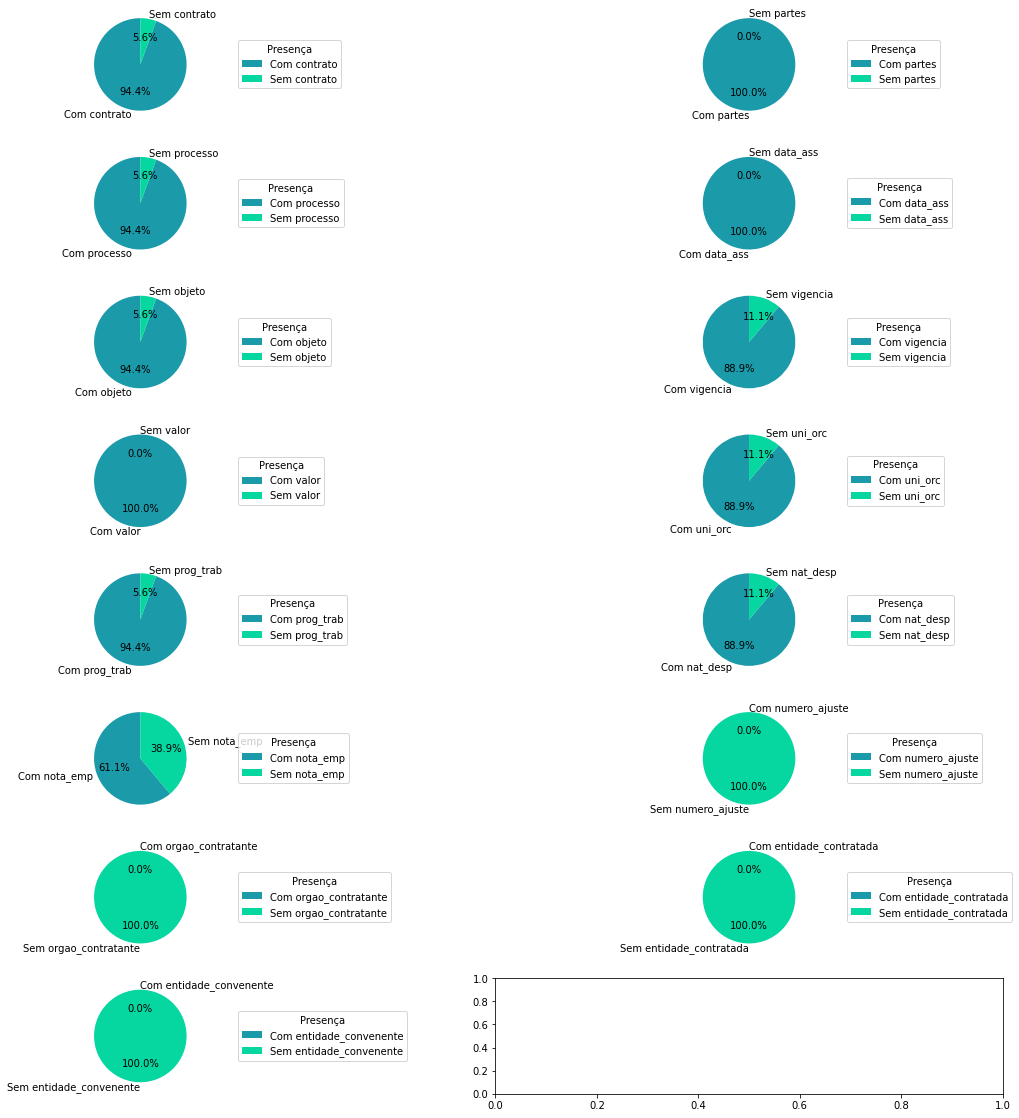

In [14]:
pizza_plots(df, 8, 2)